In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# df = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

In [ ]:
# X = df.drop("audience_count", axis=1)
# y = df["audience_count"]

In [ ]:

# from sklearn.dummy import DummyRegressor
# model = DummyRegressor(strategy="mean").fit(X, y)

In [ ]:

# X_test = df.drop("audience_count", axis=1)
# y_pred = model.predict(X_test)

In [ ]:
# submission = pd.DataFrame({
#     'ID': df['ID'],  
#     'audience_count': y_pred
# })

# submission.to_csv('submission.csv', index=False)

In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# **Importing Libraries**


In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Loading**

In [2]:
input_path = "/kaggle/input/Cinema_Audience_Forecasting_challenge"

visits_df = pd.read_csv(f"{input_path}/booknow_visits/booknow_visits.csv")
theaters_df = pd.read_csv(f"{input_path}/booknow_theaters/booknow_theaters.csv")
booking_df = pd.read_csv(f"{input_path}/booknow_booking/booknow_booking.csv")
cinepos_booking_df = pd.read_csv(f"{input_path}/cinePOS_booking/cinePOS_booking.csv")
cinepos_theaters_df = pd.read_csv(f"{input_path}/cinePOS_theaters/cinePOS_theaters.csv")
theater_relation_df = pd.read_csv(f"{input_path}/movie_theater_id_relation/movie_theater_id_relation.csv")
date_df = pd.read_csv(f"{input_path}/date_info/date_info.csv")
sample_sub = pd.read_csv(f"{input_path}/sample_submission/sample_submission.csv")

print("Data loaded successfully")

Data loaded successfully


In [3]:
sample_sub.head()

,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


# **Data Visualization **

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

booking_df["show_datetime"] = pd.to_datetime(booking_df["show_datetime"])
booking_df["booking_datetime"] = pd.to_datetime(booking_df["booking_datetime"])
cinepos_booking_df["show_datetime"] = pd.to_datetime(cinepos_booking_df["show_datetime"])
cinepos_booking_df["booking_datetime"] = pd.to_datetime(cinepos_booking_df["booking_datetime"])

booking_df["show_date"] = booking_df["show_datetime"].dt.date
cinepos_booking_df["show_date"] = cinepos_booking_df["show_datetime"].dt.date


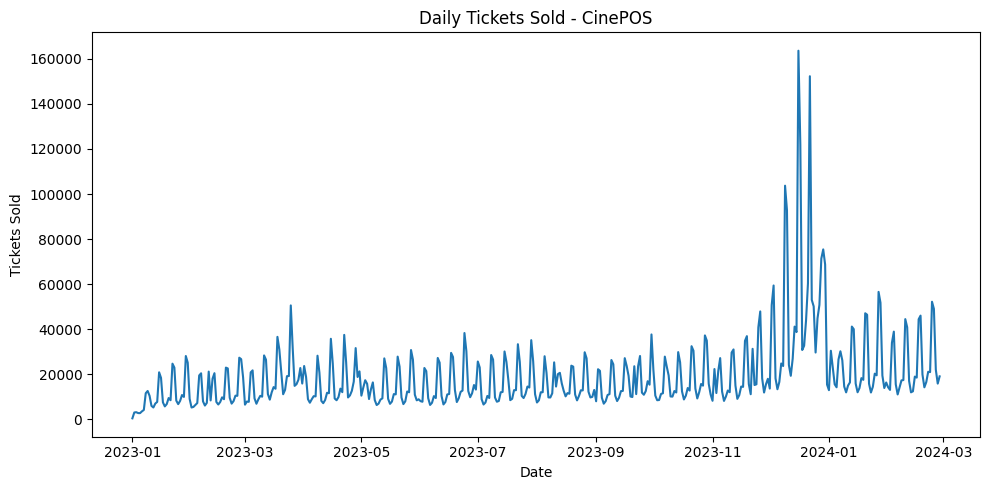

In [5]:
daily_cine = cinepos_booking_df.groupby("show_date")["tickets_sold"].sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(daily_cine["show_date"], daily_cine["tickets_sold"])
plt.title("Daily Tickets Sold - CinePOS")
plt.xlabel("Date")
plt.ylabel("Tickets Sold")
plt.tight_layout()
plt.show()


Strong weekly seasonality: clear repeating waves show low weekday audiences and much higher weekend peaks across the entire period.

Gradual growth: baseline and weekend peaks in mid–late 2023 are visibly higher than in early 2023, suggesting increasing overall footfall or expansion to more locations.

Event-driven spikes: short, sharp peaks around March–April and again mid‑year likely correspond to big‑release weeks or regional festivals driving temporary surges.

Massive year‑end shock: late December 2023 shows an extreme spike (5–7x normal peaks), consistent with one or more blockbuster releases plus holiday effect; this is an important outlier for model training.

Post‑spike regime shift: after the December peak, early‑2024 weekend levels seem structurally higher than early‑2023, hinting at a possible step‑change in user base, pricing, or screen count.

Strong calendar effects: visible patterns imply features like day‑of‑week, month, holidays, and major movie release flags should be high‑priority predictors in the Kaggle model.

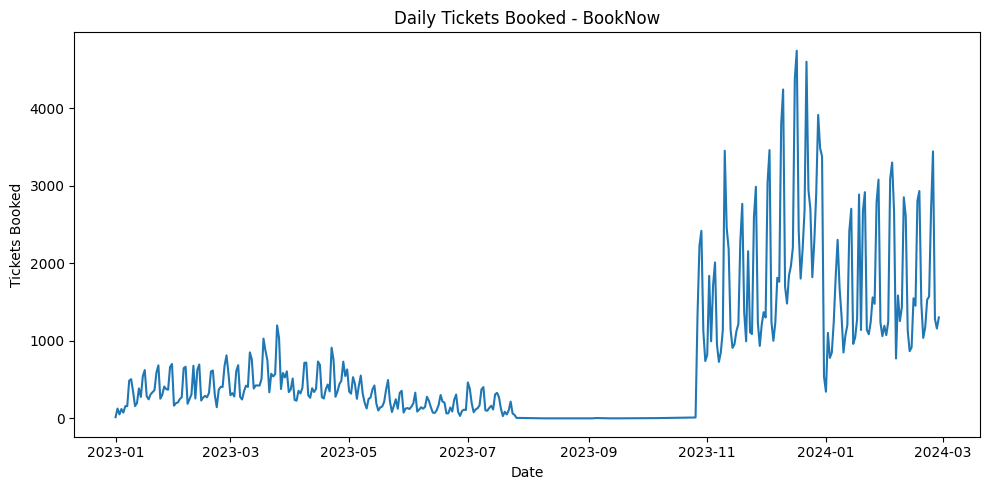

In [6]:
daily_book = booking_df.groupby("show_date")["tickets_booked"].sum().reset_index()

plt.figure(figsize=(10,5))
plt.plot(daily_book["show_date"], daily_book["tickets_booked"])
plt.title("Daily Tickets Booked - BookNow")
plt.xlabel("Date")
plt.ylabel("Tickets Booked")
plt.tight_layout()
plt.show()


Platform ramp‑up: BookNow starts with low volumes in early 2023, then ramps to ~300–800 daily bookings with weekend spikes until around May 2023.

Mid‑year drop: From roughly June to late October 2023, bookings trend down to near zero, suggesting data gaps, platform downtime, or operational pause rather than natural demand.

Relaunch / expansion: Around early November 2023, bookings jump from almost zero to 500–2,500 per day, indicating a strong relaunch, new partnerships, or marketing push.

Strong late‑year growth: Peaks reach 4,000–4,700 bookings per day in Dec 2023, showing rapid adoption and possibly more theatres or cities being integrated.

Clear weekly pattern post‑November: After the relaunch phase, there is a regular weekly cycle with higher weekend peaks and lower weekday troughs, useful for including day‑of‑week and seasonality features in the model.

Regime change for modeling: The pre‑pause, zero‑activity, and post‑November periods behave very differently, so it may help to treat them as separate regimes or add a “phase” feature when training your prediction model.

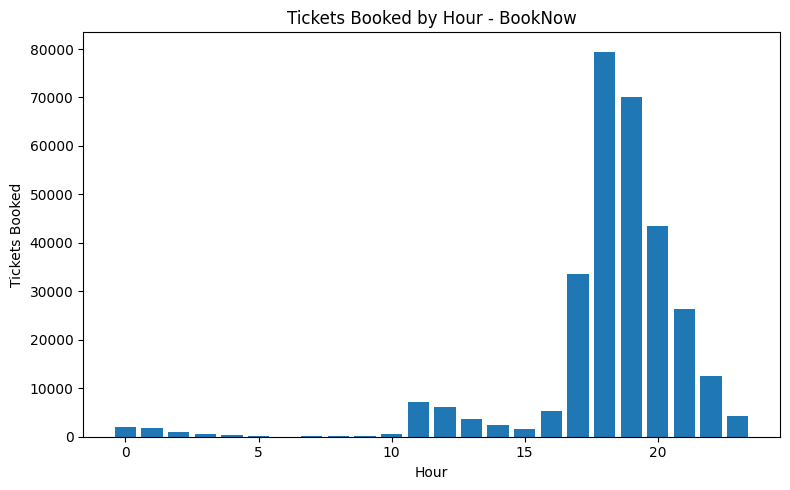

In [7]:
temp_book = booking_df.copy()
temp_book["hour"] = temp_book["show_datetime"].dt.hour
hourly_book = temp_book.groupby("hour")["tickets_booked"].sum().reset_index()

plt.figure(figsize=(8,5))
plt.bar(hourly_book["hour"], hourly_book["tickets_booked"])
plt.title("Tickets Booked by Hour - BookNow")
plt.xlabel("Hour")
plt.ylabel("Tickets Booked")
plt.tight_layout()
plt.show()


Strong evening skew: The vast majority of BookNow bookings occur between 17:00 and 22:00, with almost negligible traffic in the morning and early afternoon hours.

Peak booking window: The single highest bar is around 18:00–19:00, followed by 19:00–20:00 and 20:00–21:00, indicating a tight 3–4 hour prime conversion window.

Late‑night tail: There is a smaller but visible volume around 21:00–22:00 and 22:00–23:00, suggesting users also book just before or after typical showtimes.

Operational implication: Marketing notifications, price experiments, and infrastructure scaling should focus on the 17:00–22:00 window, since optimizing this band will impact most of the platform’s daily volume.

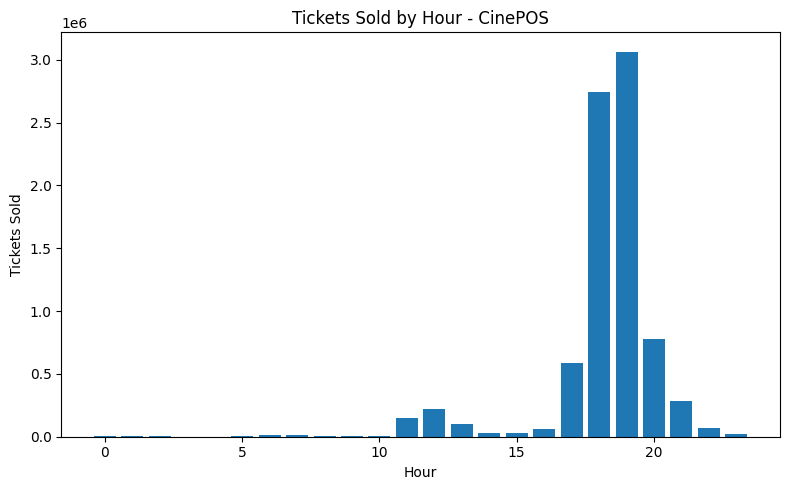

In [8]:
temp_cine = cinepos_booking_df.copy()
temp_cine["hour"] = temp_cine["show_datetime"].dt.hour
hourly_cine = temp_cine.groupby("hour")["tickets_sold"].sum().reset_index()

plt.figure(figsize=(8,5))
plt.bar(hourly_cine["hour"], hourly_cine["tickets_sold"])
plt.title("Tickets Sold by Hour - CinePOS")
plt.xlabel("Hour")
plt.ylabel("Tickets Sold")
plt.tight_layout()
plt.show()


Extremely concentrated activity: Almost all CinePOS ticket selling happens between roughly 17:00 and 21:00, with negligible sales during the rest of the day.

Dominant peak hours: 18:00–20:00 show the highest bars by a large margin, indicating these are the core transaction hours when box-office and kiosk load will be maximum.

Slight pre‑/post‑peak activity: There is modest volume around 16:00–17:00 and 20:00–21:00, suggesting some early and late buyers, but still far below the main evening spike.

Operational implication: Staffing, counter openings, and system capacity planning for CinePOS should be tightly focused on the 18:00–20:00 window, as performance issues here would impact the majority of walk‑in sales.

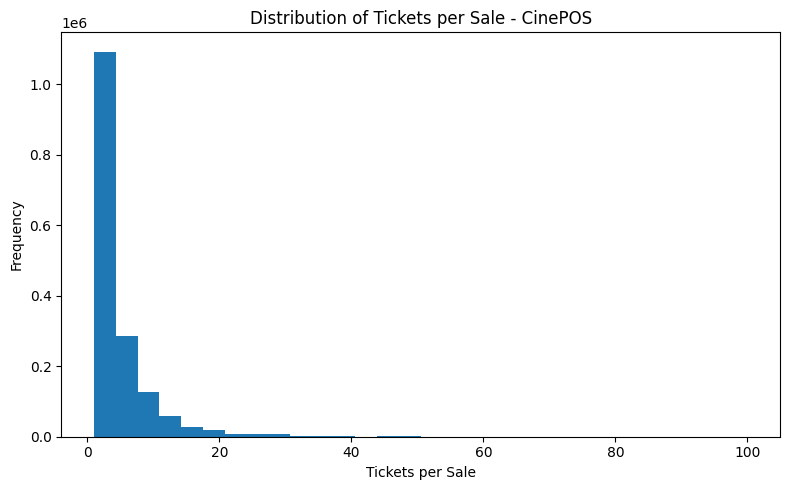

In [9]:
plt.figure(figsize=(8,5))
plt.hist(cinepos_booking_df["tickets_sold"].dropna(), bins=30)
plt.title("Distribution of Tickets per Sale - CinePOS")
plt.xlabel("Tickets per Sale")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Highly right‑skewed distribution: Most CinePOS transactions involve only a small number of tickets, with frequency dropping sharply as tickets per sale increase.

Dominance of small groups: The largest bar is in the 1–2 ticket range, indicating that individual viewers and couples make up the bulk of POS sales.

Long tail of large bookings: There are progressively fewer transactions beyond 5–10 tickets, but the tail extends up to 40–50+ tickets, representing group or corporate bookings.

Modeling implication: Average tickets per transaction is low with high variance, so features like “group size bucket” (1–2, 3–5, 6–10, 10+) could be useful for segmenting customer behavior and revenue per sale.

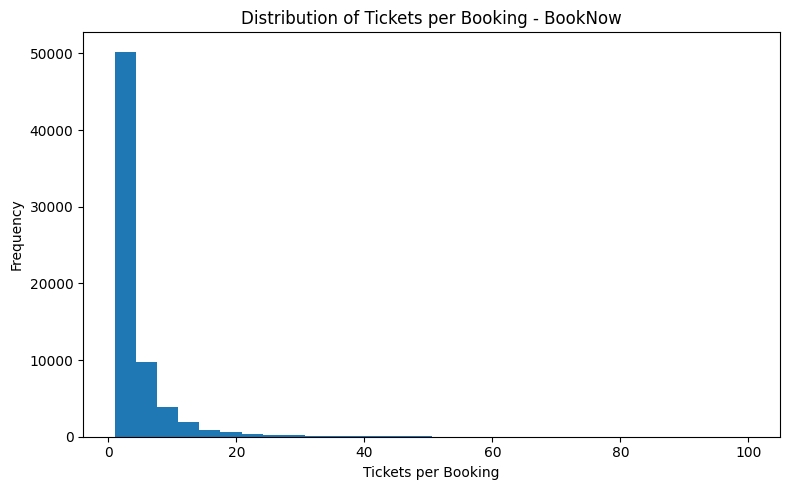

In [10]:
plt.figure(figsize=(8,5))
plt.hist(booking_df["tickets_booked"].dropna(), bins=30)
plt.title("Distribution of Tickets per Booking - BookNow")
plt.xlabel("Tickets per Booking")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Right‑skewed distribution: Most BookNow bookings contain only a small number of tickets, with frequency decreasing rapidly as tickets per booking increase.

Single/couple dominance: The tallest bars are around 1–3 tickets, indicating that individual users and pairs account for most online bookings.

Fewer medium groups: Bookings of roughly 4–8 tickets appear noticeably less frequent but still present, capturing family/group outings.

Rare large bookings: The tail stretches beyond 10–20+ tickets but with very low counts, suggesting occasional group or corporate reservations via BookNow.

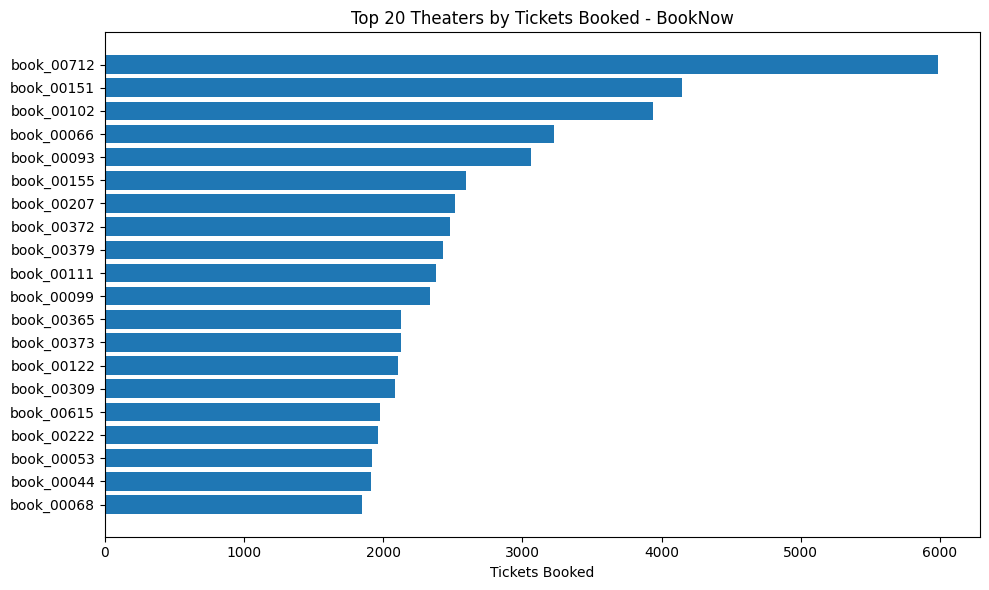

In [11]:
merged = theater_relation_df.merge(booking_df, on="book_theater_id", how="left")
book_agg = merged.groupby("book_theater_id")["tickets_booked"].sum().reset_index()
book_agg = book_agg.merge(theaters_df, on="book_theater_id", how="left")
top20 = book_agg.sort_values("tickets_booked", ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top20["book_theater_id"][::-1], top20["tickets_booked"][::-1])
plt.title("Top 20 Theaters by Tickets Booked - BookNow")
plt.xlabel("Tickets Booked")
plt.tight_layout()
plt.show()


Clear concentration of demand: A small set of theaters accounts for a large share of BookNow bookings, with the top theater (book_00712) alone crossing 6,000 tickets.

Long but shallow tail: Ticket counts drop steadily from the first few theaters to the 20th, indicating many theaters participate but only a handful are high‑volume anchors.

Priority locations: The top 3–5 theaters (e.g., book_00712, book_00151, book_00102) should be treated as key partners for focused campaigns, inventory management, and performance tuning.

Opportunity insight: Theaters toward the bottom of the top‑20 list still have significant volume (around 1,800–2,200 tickets), making them strong candidates for upsell features or local marketing to push them into the top tier.

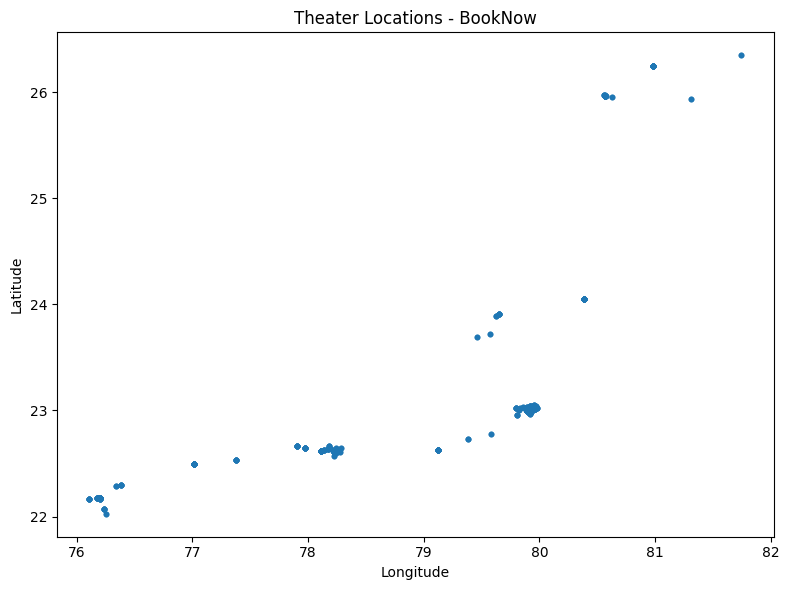

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(theaters_df["longitude"], theaters_df["latitude"], s=10)
plt.title("Theater Locations - BookNow")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


Geographically compact network: All BookNow theaters lie within a relatively narrow latitude–longitude band, suggesting coverage within a single state or region rather than nationwide deployment.

Visible city clusters: Points form tight clusters at several longitudes (around 76–76.5, 78–78.5, 79.5–80, and 80.5–82), indicating distinct city hubs where multiple partnered theaters are located.

North‑east expansion: A small group of theaters appears at higher latitudes (around 25–26.5), hinting at newer or more distant markets being served compared with the denser cluster around 22–23 latitude.

Location feature potential: Latitude/longitude or derived “city/cluster ID” can be a strong feature in your model, capturing regional differences in demand, holidays, and audience behavior.

# **EDA**

In [13]:
import pandas as pd
import numpy as np

dfs = {
    "visits_df": visits_df,
    "theaters_df": theaters_df,
    "booking_df": booking_df,
    "cinepos_booking_df": cinepos_booking_df,
    "cinepos_theaters_df": cinepos_theaters_df,
    "theater_relation_df": theater_relation_df,
    "date_df": date_df,
    "sample_sub": sample_sub
}

for name, df in dfs.items():
    print("="*70)
    print(name)
    print("Shape:", df.shape)
    display(df.head())
    display(df.dtypes)
    df.info()
    display(df.describe(include="all").T)
    display(df.isnull().sum())


visits_df
Shape: (214046, 3)


,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


book_theater_id    object
show_date          object
audience_count      int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   book_theater_id  214046 non-null  object
 1   show_date        214046 non-null  object
 2   audience_count   214046 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
book_theater_id,214046,826,book_00528,424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
show_date,214046,424,2023-11-18,783,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audience_count,214046.0,NaN,NaN,NaN,41.616568,32.834918,2.0,18.0,34.0,58.0,1350.0


book_theater_id    0
show_date          0
audience_count     0
dtype: int64

theaters_df
Shape: (829, 5)


,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


book_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   book_theater_id  314 non-null    object 
 1   theater_type     829 non-null    object 
 2   theater_area     829 non-null    object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
book_theater_id,314,314,book_00093,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_type,829,4,Other,411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_area,829,103,Area_003,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,829.0,NaN,NaN,NaN,23.0,0.833863,22.02597,22.619233,23.00441,23.018784,26.349436
longitude,829.0,NaN,NaN,NaN,79.0,1.460388,76.112098,78.170501,79.908065,79.934515,81.743235


book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64

booking_df
Shape: (68336, 5)


,book_theater_id,show_datetime,booking_datetime,tickets_booked,show_date
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1,2023-01-01
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3,2023-01-01
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6,2023-01-01
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2,2023-01-01
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5,2023-01-01


book_theater_id             object
show_datetime       datetime64[ns]
booking_datetime    datetime64[ns]
tickets_booked               int64
show_date                   object
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   book_theater_id   68336 non-null  object        
 1   show_datetime     68336 non-null  datetime64[ns]
 2   booking_datetime  68336 non-null  datetime64[ns]
 3   tickets_booked    68336 non-null  int64         
 4   show_date         68336 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 2.6+ MB


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
book_theater_id,68336,301,book_00712,1832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
show_datetime,68336,NaN,NaN,NaN,2023-10-26 00:47:08.172559104,2023-01-01 19:00:00,2023-10-29 17:00:00,2023-12-13 18:00:00,2024-01-20 17:00:00,2024-02-28 23:00:00,NaN
booking_datetime,68336,NaN,NaN,NaN,2023-10-16 22:53:05.717630720,2023-01-01 01:00:00,2023-09-08 18:00:00,2023-12-02 22:00:00,2024-01-12 18:00:00,2024-02-28 22:00:00,NaN
tickets_booked,68336.0,NaN,NaN,NaN,4.425808,1.0,2.0,3.0,5.0,100.0,4.808945
show_date,68336,340,2023-12-24,1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN


book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
show_date           0
dtype: int64

cinepos_booking_df
Shape: (1641966, 5)


,cine_theater_id,show_datetime,booking_datetime,tickets_sold,show_date
0,cinePOS_00001,2023-01-01 11:00:00,2023-01-01 09:00:00,1,2023-01-01
1,cinePOS_00002,2023-01-01 13:00:00,2023-01-01 06:00:00,3,2023-01-01
2,cinePOS_00003,2023-01-01 16:00:00,2023-01-01 14:00:00,2,2023-01-01
3,cinePOS_00004,2023-01-01 17:00:00,2023-01-01 11:00:00,5,2023-01-01
4,cinePOS_00005,2023-01-01 17:00:00,2023-01-01 03:00:00,13,2023-01-01


cine_theater_id             object
show_datetime       datetime64[ns]
booking_datetime    datetime64[ns]
tickets_sold                 int64
show_date                   object
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641966 entries, 0 to 1641965
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   cine_theater_id   1641966 non-null  object        
 1   show_datetime     1641966 non-null  datetime64[ns]
 2   booking_datetime  1641966 non-null  datetime64[ns]
 3   tickets_sold      1641966 non-null  int64         
 4   show_date         1641966 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 62.6+ MB


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
cine_theater_id,1641966,13161,cinePOS_03019,921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
show_datetime,1641966,NaN,NaN,NaN,2023-09-08 21:03:44.408300544,2023-01-01 11:00:00,2023-05-28 18:00:00,2023-10-01 21:00:00,2023-12-22 19:00:00,2024-02-28 23:00:00,NaN
booking_datetime,1641966,NaN,NaN,NaN,2023-09-01 10:53:33.485297664,2023-01-01 00:00:00,2023-05-22 18:00:00,2023-09-26 21:00:00,2023-12-13 13:00:00,2024-02-28 21:00:00,NaN
tickets_sold,1641966.0,NaN,NaN,NaN,4.987345,1.0,2.0,3.0,6.0,100.0,5.234901
show_date,1641966,424,2023-12-22,21269,NaN,NaN,NaN,NaN,NaN,NaN,NaN


cine_theater_id     0
show_datetime       0
booking_datetime    0
tickets_sold        0
show_date           0
dtype: int64

cinepos_theaters_df
Shape: (4690, 5)


,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


cine_theater_id     object
theater_type        object
theater_area        object
latitude           float64
longitude          float64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cine_theater_id  4690 non-null   object 
 1   theater_type     4690 non-null   object 
 2   theater_area     4690 non-null   object 
 3   latitude         829 non-null    float64
 4   longitude        829 non-null    float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cine_theater_id,4690,4690,cinePOS_05466,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_type,4690,3,Other,3941,NaN,NaN,NaN,NaN,NaN,NaN,NaN
theater_area,4690,119,Area_119,257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,829.0,NaN,NaN,NaN,23.0,0.833863,22.02597,22.619233,23.00441,23.018784,26.349436
longitude,829.0,NaN,NaN,NaN,79.0,1.460388,76.112098,78.170501,79.908065,79.934515,81.743235


cine_theater_id       0
theater_type          0
theater_area          0
latitude           3861
longitude          3861
dtype: int64

theater_relation_df
Shape: (150, 2)


,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


book_theater_id    object
cine_theater_id    object
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   book_theater_id  150 non-null    object
 1   cine_theater_id  150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


,count,unique,top,freq
book_theater_id,150,150,book_00509,1
cine_theater_id,150,150,cinePOS_01261,1


book_theater_id    0
cine_theater_id    0
dtype: int64

date_df
Shape: (547, 2)


,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


show_date      object
day_of_week    object
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_date    547 non-null    object
 1   day_of_week  547 non-null    object
dtypes: object(2)
memory usage: 8.7+ KB


,count,unique,top,freq
show_date,547,547,2023-01-01,1
day_of_week,547,7,Sunday,79


show_date      0
day_of_week    0
dtype: int64

sample_sub
Shape: (38062, 2)


,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


ID                object
audience_count     int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38062 entries, 0 to 38061
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              38062 non-null  object
 1   audience_count  38062 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 594.8+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,38062,38062,book_00001_2024-03-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audience_count,38062.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ID                0
audience_count    0
dtype: int64

theaters_df - Numeric Summary


,count,mean,std,min,25%,50%,75%,max
latitude,829.0,23.0,0.833863,22.025970,22.619233,23.004410,23.018784,26.349436
longitude,829.0,79.0,1.460388,76.112098,78.170501,79.908065,79.934515,81.743235


latitude     2.657947
longitude   -0.937729
dtype: float64

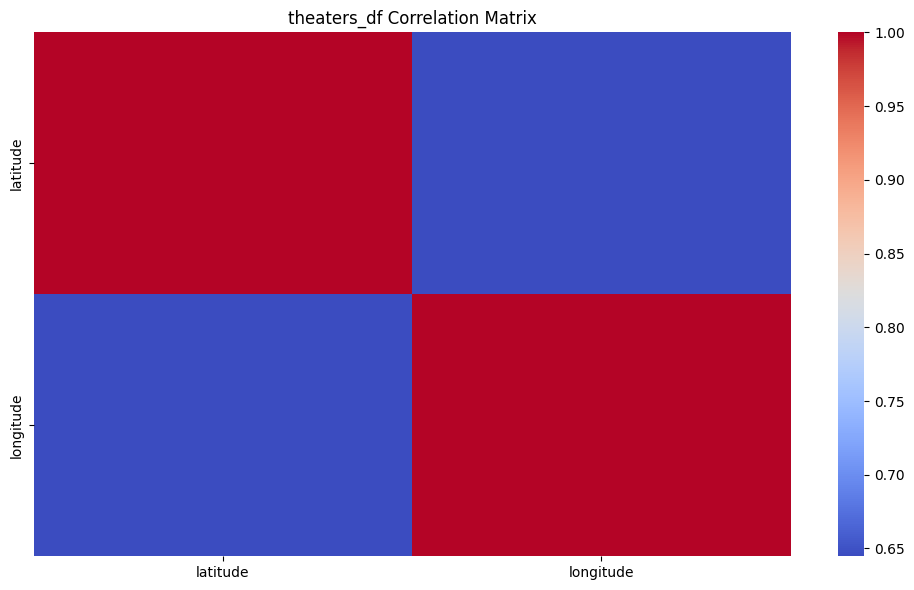

cinepos_theaters_df - Numeric Summary


,count,mean,std,min,25%,50%,75%,max
latitude,829.0,23.0,0.833863,22.025970,22.619233,23.004410,23.018784,26.349436
longitude,829.0,79.0,1.460388,76.112098,78.170501,79.908065,79.934515,81.743235


latitude     2.657947
longitude   -0.937729
dtype: float64

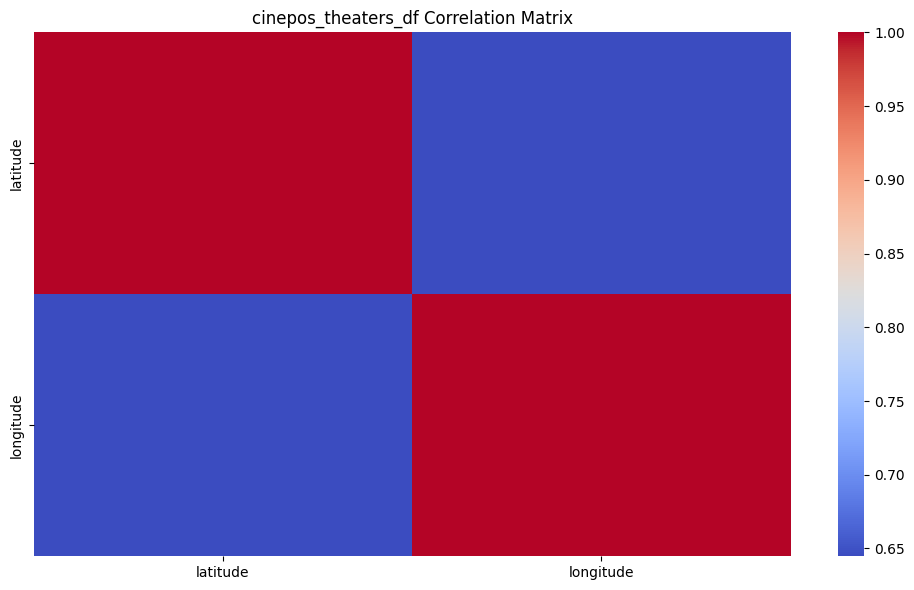

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, df in dfs.items():
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] > 1:
        print("="*70)
        print(name, "- Numeric Summary")
        display(num.describe().T)
        display(num.skew())
        corr = num.corr()
        plt.figure(figsize=(10,6))
        sns.heatmap(corr, cmap="coolwarm")
        plt.title(name + " Correlation Matrix")
        plt.tight_layout()
        plt.show()


This combined view is giving you a quick numeric and visual sanity check for both BookNow and CinePOS theater locations.

The numeric summaries at the top show that latitude and longitude for both datasets have almost identical ranges, means, and percentiles, which confirms the two platforms operate over the same geographic region.

The correlation heatmaps for both theaters_df and cinepos_theaters_df show the same pattern: latitude and longitude are not strongly linearly correlated with each other (off‑diagonal is far from 1), but each is perfectly correlated with itself on the diagonal.

Taken together, this says: (1) your location data is consistent across the two sources, and (2) latitude and longitude each add independent spatial information, so both are worth keeping or transforming into derived features like city/cluster IDs or distance‑based features.

In [15]:
for name, df in dfs.items():
    cat = df.select_dtypes(include=["object", "category"])
    if cat.shape[1] > 0:
        print("="*70)
        print(name, "- Categorical Summary")
        for c in cat.columns:
            print(c)
            display(df[c].value_counts(dropna=False).head(10))


visits_df - Categorical Summary
book_theater_id


book_theater_id
book_00528    424
book_00597    424
book_00676    423
book_00703    423
book_00580    422
book_00763    422
book_00394    422
book_00670    421
book_00350    421
book_00021    420
Name: count, dtype: int64

show_date


show_date
2023-11-18    783
2023-12-16    782
2024-01-27    781
2024-01-20    780
2024-02-03    780
2023-10-21    779
2024-02-17    779
2023-10-14    778
2023-12-09    777
2023-09-16    775
Name: count, dtype: int64

theaters_df - Categorical Summary
book_theater_id


book_theater_id
NaN           515
book_00093      1
book_00187      1
book_00242      1
book_00177      1
book_00059      1
book_00179      1
book_00273      1
book_00031      1
book_00194      1
Name: count, dtype: int64

theater_type


theater_type
Other     411
Comedy    196
Drama     183
Action     39
Name: count, dtype: int64

theater_area


theater_area
Area_003    64
Area_006    58
Area_002    51
Area_010    39
Area_004    30
Area_018    29
Area_005    25
Area_008    23
Area_011    22
Area_016    21
Name: count, dtype: int64

booking_df - Categorical Summary
book_theater_id


book_theater_id
book_00712    1832
book_00082    1562
book_00102    1287
book_00105    1223
book_00376    1160
book_00103    1146
book_00031    1116
book_00114    1008
book_00106     949
book_00091     940
Name: count, dtype: int64

show_date


show_date
2023-12-24    1013
2023-12-17     859
2023-12-22     822
2024-02-25     818
2023-12-23     792
2023-12-29     789
2023-12-10     784
2024-02-04     768
2023-12-16     765
2023-12-30     741
Name: count, dtype: int64

cinepos_booking_df - Categorical Summary
cine_theater_id


cine_theater_id
cinePOS_03019    921
cinePOS_05965    679
cinePOS_10811    669
cinePOS_03773    647
cinePOS_05725    646
cinePOS_00943    635
cinePOS_00706    625
cinePOS_04169    608
cinePOS_05593    604
cinePOS_05316    603
Name: count, dtype: int64

show_date


show_date
2023-12-22    21269
2023-12-16    21083
2023-12-17    20081
2023-12-24    19006
2023-12-10    15770
2023-12-29    15065
2023-12-09    14500
2023-12-30    13954
2023-12-23    12707
2023-12-28    12610
Name: count, dtype: int64

cinepos_theaters_df - Categorical Summary
cine_theater_id


cine_theater_id
cinePOS_05466    1
cinePOS_12739    1
cinePOS_05443    1
cinePOS_13124    1
cinePOS_05340    1
cinePOS_12713    1
cinePOS_03690    1
cinePOS_12397    1
cinePOS_01970    1
cinePOS_07026    1
Name: count, dtype: int64

theater_type


theater_type
Other     3941
Drama      705
Action      44
Name: count, dtype: int64

theater_area


theater_area
Area_119    257
Area_009    198
Area_110    163
Area_111    150
Area_145    145
Area_108    135
Area_112    127
Area_146    122
Area_133    119
Area_126    117
Name: count, dtype: int64

theater_relation_df - Categorical Summary
book_theater_id


book_theater_id
book_00509    1
book_00067    1
book_00037    1
book_00379    1
book_00107    1
book_00694    1
book_00310    1
book_00119    1
book_00034    1
book_00098    1
Name: count, dtype: int64

cine_theater_id


cine_theater_id
cinePOS_01261    1
cinePOS_01623    1
cinePOS_11682    1
cinePOS_02027    1
cinePOS_07949    1
cinePOS_01881    1
cinePOS_08715    1
cinePOS_07938    1
cinePOS_02763    1
cinePOS_05698    1
Name: count, dtype: int64

date_df - Categorical Summary
show_date


show_date
2023-01-01    1
2024-01-03    1
2023-12-28    1
2023-12-29    1
2023-12-30    1
2023-12-31    1
2024-01-01    1
2024-01-02    1
2024-01-04    1
2024-02-15    1
Name: count, dtype: int64

day_of_week


day_of_week
Sunday       79
Monday       78
Tuesday      78
Wednesday    78
Thursday     78
Friday       78
Saturday     78
Name: count, dtype: int64

sample_sub - Categorical Summary
ID


ID
book_00001_2024-03-01    1
book_00554_2024-04-05    1
book_00554_2024-04-07    1
book_00554_2024-04-08    1
book_00554_2024-04-09    1
book_00554_2024-04-10    1
book_00554_2024-04-11    1
book_00554_2024-04-12    1
book_00554_2024-04-13    1
book_00554_2024-04-14    1
Name: count, dtype: int64

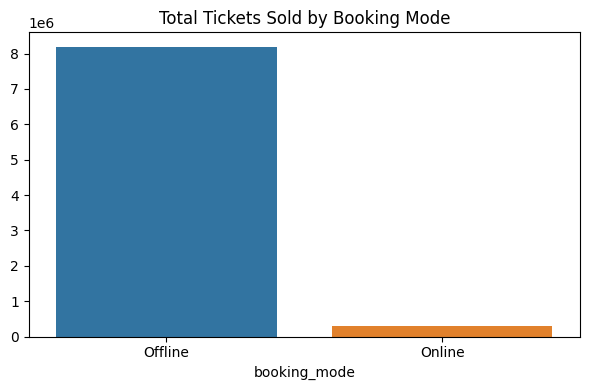

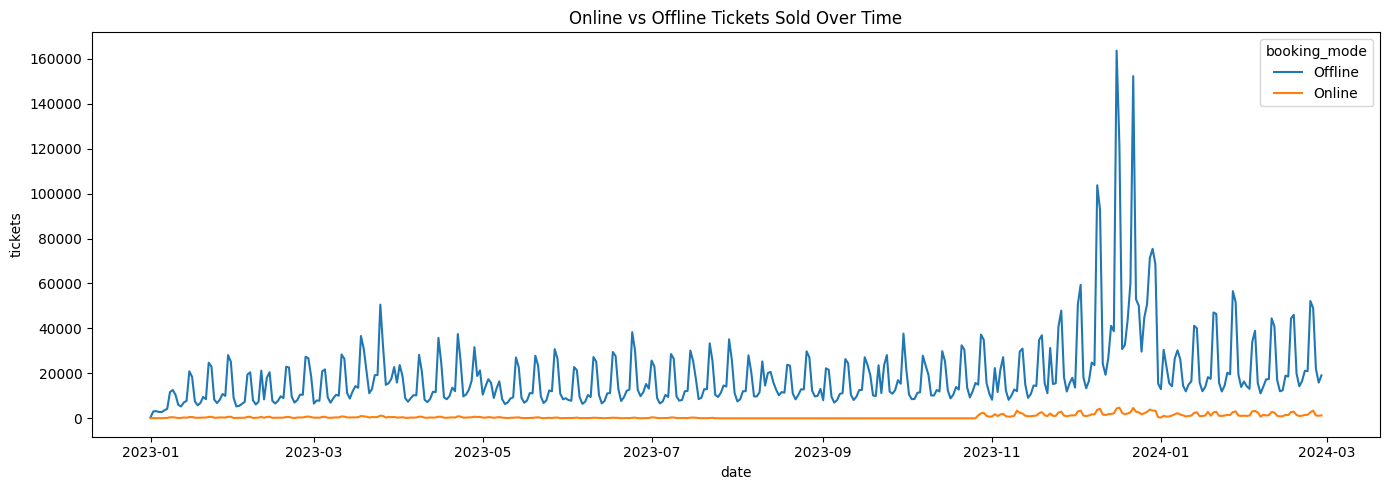

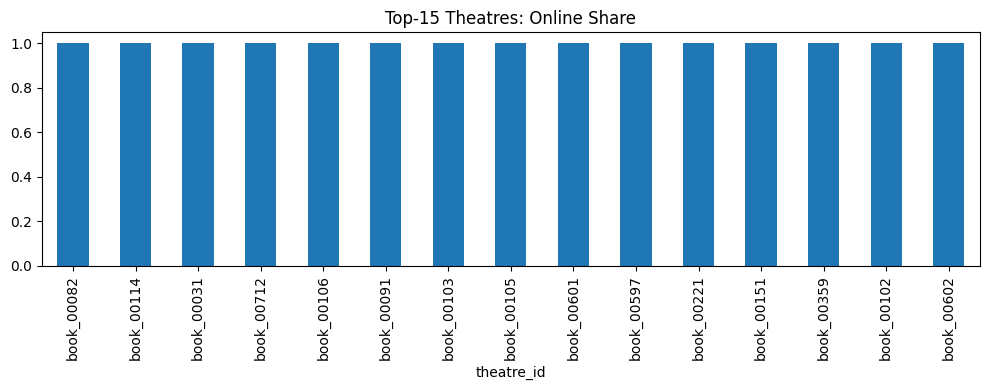

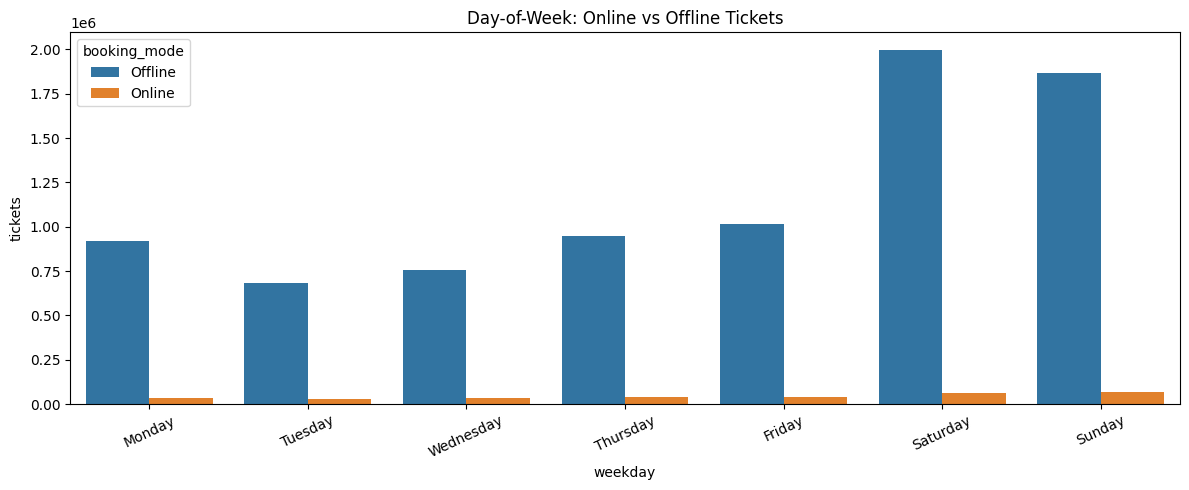

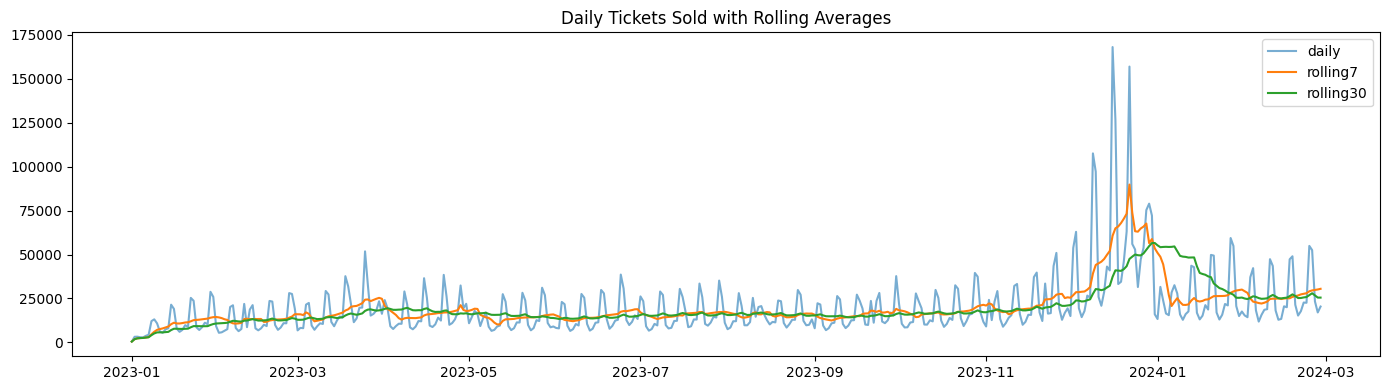

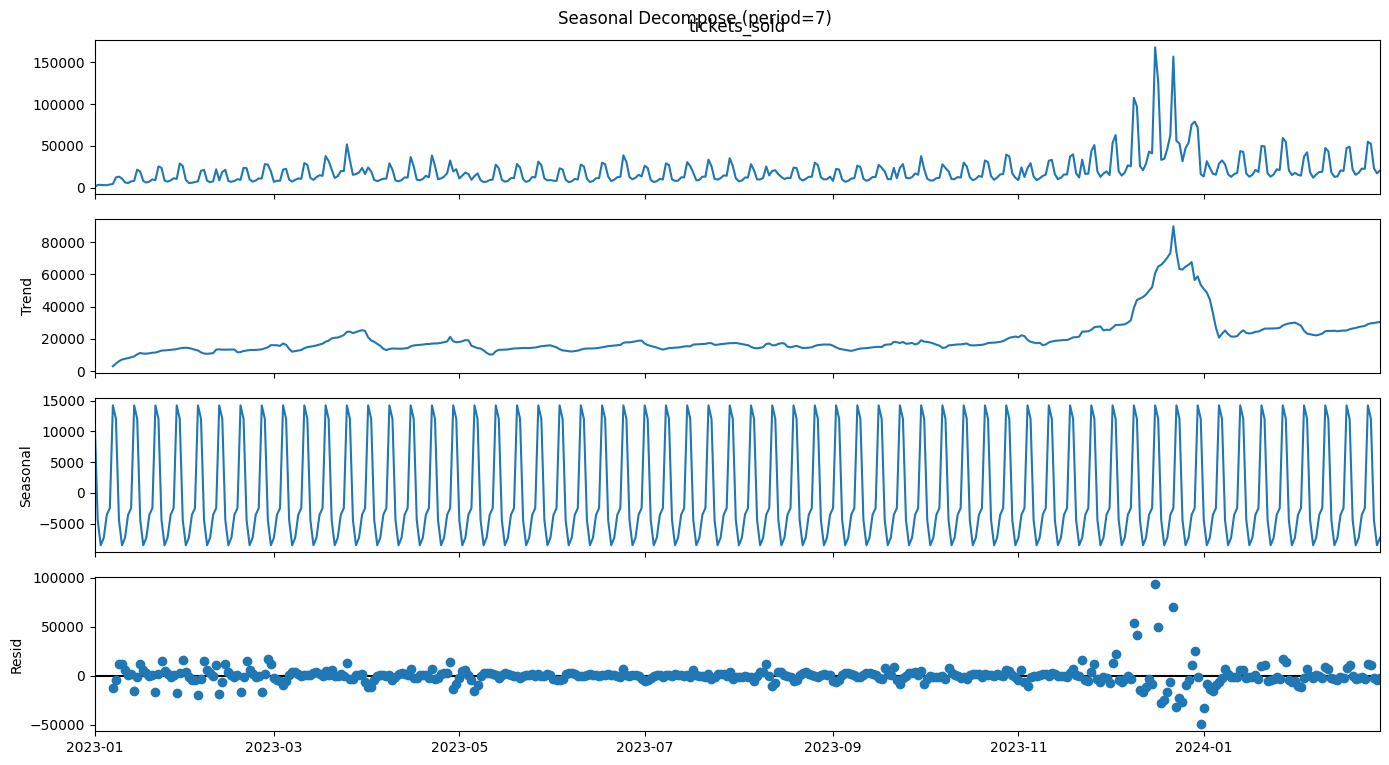

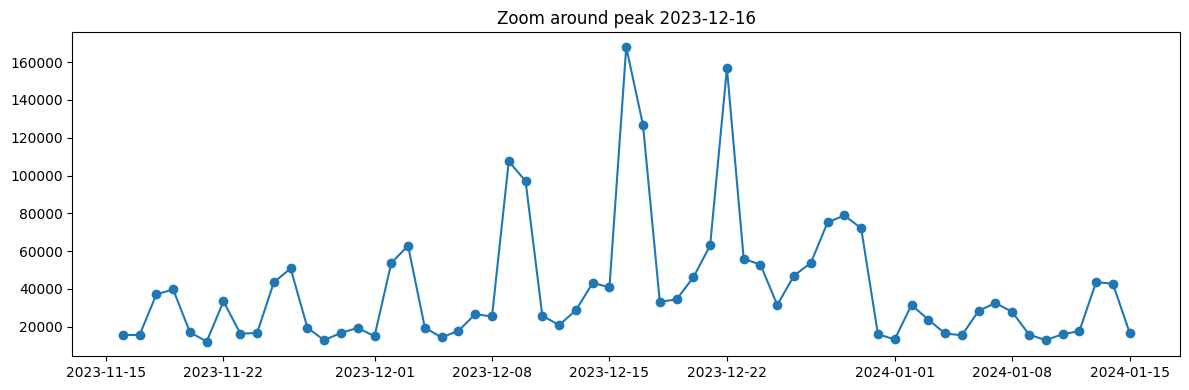

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12,4)

# --- Prepare BookNow (Online) ---
book = booking_df.copy()
book['date'] = pd.to_datetime(book['show_datetime']).dt.date
book = book.rename(columns={
    'book_theater_id': 'theatre_id',
    'tickets_booked': 'tickets'
})
book = book[['date', 'theatre_id', 'tickets']]
book['booking_mode'] = 'Online'
book['date'] = pd.to_datetime(book['date'])

# --- Prepare CinePOS (Offline) ---
cine = cinepos_booking_df.copy()
cine['date'] = pd.to_datetime(cine['show_datetime']).dt.date
cine = cine.rename(columns={
    'cine_theater_id': 'theatre_id',
    'tickets_sold': 'tickets'
})
cine = cine[['date', 'theatre_id', 'tickets']]
cine['booking_mode'] = 'Offline'
cine['date'] = pd.to_datetime(cine['date'])

# --- Combine ---
combined_bookings = pd.concat([book, cine], ignore_index=True)
combined_bookings = combined_bookings.dropna(subset=['date']).reset_index(drop=True)

# --- Total Online vs Offline ---
totals = combined_bookings.groupby('booking_mode')['tickets'].sum()
plt.figure(figsize=(6,4))
sns.barplot(x=totals.index, y=totals.values)
plt.title("Total Tickets Sold by Booking Mode")
plt.tight_layout()
plt.show()

# --- Trend Over Time ---
daily_mode = combined_bookings.groupby(['date','booking_mode'])['tickets'].sum().reset_index()
plt.figure(figsize=(14,5))
sns.lineplot(data=daily_mode, x='date', y='tickets', hue='booking_mode')
plt.title("Online vs Offline Tickets Sold Over Time")
plt.tight_layout()
plt.show()

# --- Theatre-wise Online Share ---
theatre_mode = combined_bookings.groupby(['theatre_id','booking_mode'])['tickets'].sum().unstack(fill_value=0)
for col in ['Online','Offline']:
    if col not in theatre_mode.columns:
        theatre_mode[col] = 0

theatre_mode['online_share'] = theatre_mode['Online'] / (theatre_mode['Online'] + theatre_mode['Offline'])
theatre_mode['total_tickets'] = theatre_mode['Online'] + theatre_mode['Offline']

top15 = theatre_mode.sort_values('total_tickets', ascending=False).head(15)
plt.figure(figsize=(10,4))
top15['online_share'].sort_values(ascending=False).plot(kind='bar')
plt.title("Top-15 Theatres: Online Share")
plt.tight_layout()
plt.show()

# --- Day-of-week Online vs Offline ---
combined_bookings['weekday'] = combined_bookings['date'].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow = combined_bookings.groupby(['weekday','booking_mode'])['tickets'].sum().reset_index()
dow['weekday'] = pd.Categorical(dow['weekday'], categories=order, ordered=True)

plt.figure(figsize=(12,5))
sns.barplot(data=dow, x='weekday', y='tickets', hue='booking_mode')
plt.title("Day-of-Week: Online vs Offline Tickets")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# --- Time-series Deep EDA ---
daily_total = combined_bookings.groupby('date')['tickets'].sum().rename('tickets_sold').to_frame()
daily_total = daily_total.asfreq('D', fill_value=0)

daily_total['rolling7'] = daily_total['tickets_sold'].rolling(7, min_periods=1).mean()
daily_total['rolling30'] = daily_total['tickets_sold'].rolling(30, min_periods=1).mean()
daily_total['lag1'] = daily_total['tickets_sold'].shift(1)
daily_total['lag7'] = daily_total['tickets_sold'].shift(7)

plt.figure(figsize=(14,4))
plt.plot(daily_total.index, daily_total['tickets_sold'], alpha=0.6, label='daily')
plt.plot(daily_total.index, daily_total['rolling7'], label='rolling7')
plt.plot(daily_total.index, daily_total['rolling30'], label='rolling30')
plt.title("Daily Tickets Sold with Rolling Averages")
plt.legend()
plt.tight_layout()
plt.show()

try:
    decomp = seasonal_decompose(daily_total['tickets_sold'], model='additive', period=7, two_sided=False)
    fig = decomp.plot()
    fig.set_size_inches(14,8)
    plt.suptitle("Seasonal Decompose (period=7)", y=0.95)
    plt.tight_layout()
    plt.show()
except:
    pass

mu = daily_total['tickets_sold'].mean()
sigma = daily_total['tickets_sold'].std()
outliers = daily_total[daily_total['tickets_sold'] > mu + 3*sigma]

if len(outliers) > 0:
    peak_date = outliers['tickets_sold'].idxmax()
    window = daily_total.loc[peak_date - pd.Timedelta(days=30): peak_date + pd.Timedelta(days=30)]
    plt.figure(figsize=(12,4))
    plt.plot(window.index, window['tickets_sold'], marker='o')
    plt.title(f"Zoom around peak {peak_date.date()}")
    plt.tight_layout()
    plt.show()


# **Cleaning and Validating Theater Data**

In [17]:
theaters_df = theaters_df.dropna(subset=['book_theater_id'])
missing = theaters_df['book_theater_id'].isnull().sum()
print(f'Cleaned missing theater records: {missing}')

Cleaned missing theater records: 0


# **Converting Show Dates to Datetime Format**

In [18]:
visits_df['show_date'] = pd.to_datetime(visits_df['show_date'])
date_df['show_date'] = pd.to_datetime(date_df['show_date'])

# **Aggregating Booking Information**

In [19]:
booking_df['show_date'] = pd.to_datetime(booking_df['show_datetime']).dt.date
booking_df['show_date'] = pd.to_datetime(booking_df['show_date'])
booking_agg = booking_df.groupby(['book_theater_id', 'show_date'], as_index=False)['tickets_booked'].sum()

# **Merging All DataFrames**

In [20]:
df = visits_df.merge(date_df, on='show_date', how='left')
df = df.merge(theaters_df[['book_theater_id', 'theater_type', 'theater_area']], on='book_theater_id', how='left')

# **Extracting Date-Based Features**

In [21]:
df['month'] = df['show_date'].dt.month
df['week'] = df['show_date'].dt.isocalendar().week
df['day_num'] = df['show_date'].dt.dayofweek
df['day'] = df['show_date'].dt.day
df['quarter'] = df['show_date'].dt.quarter
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
df['is_month_start'] = (df['day'] <= 7).astype(int)
df['is_month_end'] = (df['day'] >= 24).astype(int)

# **Identifying Seasonal Patterns**

In [22]:
df['is_peak_season'] = df['month'].isin([5, 6, 11, 12]).astype(int)
df['is_holiday_season'] = df['month'].isin([10, 11, 12, 1]).astype(int)
df['is_mid_year'] = df['month'].isin([4, 5, 6, 7]).astype(int)

# **Merging Bookings and Theater Information**

In [23]:
df = df.merge(booking_agg, on=['book_theater_id', 'show_date'], how='left')
df['tickets_booked'] = df['tickets_booked'].fillna(0)

df['theater_type'] = df['theater_type'].fillna('Unknown')
df['theater_area'] = df['theater_area'].fillna('Unknown')

# **Computing Theater-Level Metrics**

In [24]:
theater_metrics = df.groupby('book_theater_id')['audience_count'].agg(['mean', 'median', 'std']).reset_index()
theater_metrics.columns = ['book_theater_id', 'theater_mean', 'theater_median', 'theater_std']
df = df.merge(theater_metrics, on='book_theater_id', how='left')

# **Computing Area-Level Metrics**

In [25]:
area_metrics = df.groupby('theater_area')['audience_count'].agg(['mean', 'median']).reset_index()
area_metrics.columns = ['theater_area', 'area_mean', 'area_median']
df = df.merge(area_metrics, on='theater_area', how='left')

# **Computing Theater-Type-Level Metrics**

In [26]:
type_metrics = df.groupby('theater_type')['audience_count'].agg(['mean', 'median']).reset_index()
type_metrics.columns = ['theater_type', 'type_mean', 'type_median']
df = df.merge(type_metrics, on='theater_type', how='left')


# **Creating Ticket-Based Features**

In [27]:
df['has_tickets'] = (df['tickets_booked'] > 0).astype(int)
df['ticket_category'] = pd.cut(df['tickets_booked'], bins=[-1, 0, 3, 10, 50, 1000], labels=[0, 1, 2, 3, 4])

print(f"Feature engineering complete: {df.shape}")

Feature engineering complete: (214046, 27)


# **Encoding Categorical Features**

In [28]:
df['day_encoded'] = pd.factorize(df['day_of_week'])[0]
df['area_encoded'] = pd.factorize(df['theater_area'])[0]
df['type_encoded'] = pd.factorize(df['theater_type'])[0]

df = pd.get_dummies(df, columns=['theater_type'], prefix='type', drop_first=True)

print(f"Dataset prepared: {df.shape}")

Dataset prepared: (214046, 33)


In [29]:
df

,book_theater_id,show_date,audience_count,day_of_week,theater_area,month,week,day_num,day,quarter,...,type_median,has_tickets,ticket_category,day_encoded,area_encoded,type_encoded,type_Comedy,type_Drama,type_Other,type_Unknown
0,book_00001,2023-01-13,50,Friday,Area_002,1,2,4,13,1,...,36.0,0,0,0,0,0,False,True,False,False
1,book_00001,2023-01-14,64,Saturday,Area_002,1,2,5,14,1,...,36.0,0,0,1,0,0,False,True,False,False
2,book_00001,2023-01-15,58,Sunday,Area_002,1,2,6,15,1,...,36.0,0,0,2,0,0,False,True,False,False
3,book_00001,2023-01-16,44,Monday,Area_002,1,3,0,16,1,...,36.0,0,0,3,0,0,False,True,False,False
4,book_00001,2023-01-18,12,Wednesday,Area_002,1,3,2,18,1,...,36.0,0,0,4,0,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214041,book_00829,2024-02-23,16,Friday,Unknown,2,8,4,23,1,...,32.0,0,0,0,71,4,False,False,False,True
214042,book_00829,2024-02-24,8,Saturday,Unknown,2,8,5,24,1,...,32.0,0,0,1,71,4,False,False,False,True
214043,book_00829,2024-02-25,16,Sunday,Unknown,2,8,6,25,1,...,32.0,0,0,2,71,4,False,False,False,True
214044,book_00829,2024-02-27,16,Tuesday,Unknown,2,9,1,27,1,...,32.0,0,0,6,71,4,False,False,False,True


# **Selecting Model Features**

In [30]:
features = [
    'month', 'week', 'day_num', 'day', 'quarter', 'is_weekend', 
    'is_month_start', 'is_month_end', 'is_peak_season', 'is_holiday_season', 'is_mid_year',
    'day_encoded', 'tickets_booked', 'has_tickets', 'ticket_category',
    'theater_mean', 'theater_median', 'theater_std',
    'area_mean', 'area_median', 'type_mean', 'type_median',
    'area_encoded', 'type_encoded'
]
type_cols = [c for c in df.columns if c.startswith('type_')]
features.extend(type_cols)

print(f"Using {len(features)} features")

Using 31 features


# **Cleaning the Dataset for Modeling**

In [31]:
df_clean = df.dropna(subset=features + ['audience_count'])
df_clean = df_clean.sort_values('show_date').reset_index(drop=True)

# **Creating Train–Validation Split (Time-Based)**

In [32]:
split_date = df_clean['show_date'].max() - pd.Timedelta(days=60)
train = df_clean[df_clean['show_date'] < split_date]
val = df_clean[df_clean['show_date'] >= split_date]

print(f'Train: {train["show_date"].min()} to {train["show_date"].max()} | Samples: {len(train)}')
print(f'Val: {val["show_date"].min()} to {val["show_date"].max()} | Samples: {len(val)}')

Train: 2023-01-01 00:00:00 to 2023-12-29 00:00:00 | Samples: 173649
Val: 2023-12-30 00:00:00 to 2024-02-28 00:00:00 | Samples: 40395


# **Preparing Training and Validation Sets and Feature Scaling**

In [33]:
X_train = train[features].fillna(0)
y_train = train['audience_count']
X_val = val[features].fillna(0)
y_val = val['audience_count']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, svd_solver="full", random_state=42)

X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

pca_variance = pca.explained_variance_ratio_
pca_cumulative = pca.explained_variance_ratio_.cumsum()

print("PCA Explained Variance Ratio:")
print(pca_variance)

print("\nPCA Cumulative Explained Variance:")
print(pca_cumulative)


PCA Explained Variance Ratio:
[0.2540205  0.12400162 0.09601606 0.07985462 0.07446792 0.06868075
 0.0611971  0.04550151 0.03914132 0.03358956 0.0246976  0.02213544
 0.01788617 0.01308697]

PCA Cumulative Explained Variance:
[0.2540205  0.37802212 0.47403819 0.55389281 0.62836073 0.69704148
 0.75823858 0.80374009 0.84288141 0.87647097 0.90116856 0.923304
 0.94119017 0.95427714]


# **Training Gradient Boosting Regressor**

In [35]:
gb_model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train, y_train)

KeyboardInterrupt: 

# **Training Extra Trees Regressor**

In [ ]:
et_model = ExtraTreesRegressor(
    n_estimators=120,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=6,
    max_features=0.7,
    random_state=42,
    n_jobs=-1
)
et_model.fit(X_train, y_train)

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_pca, y_train)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

models = {"GradientBoosting": gb_model, "ExtraTrees": et_model, "RandomForest": rf_model}

def n_features(m):
    return getattr(m, "n_features_in_", None)

candidates = {}
if "X_val" in globals():
    Xa = np.asarray(X_val)
    candidates["X_val"] = Xa
if "X_val_scaled" in globals():
    candidates["X_val_scaled"] = np.asarray(X_val_scaled)
if "X_val_pca" in globals():
    candidates["X_val_pca"] = np.asarray(X_val_pca)
if "X_val_t" in globals():
    candidates["X_val_t"] = np.asarray(X_val_t)
if "X_val_transformed" in globals():
    candidates["X_val_transformed"] = np.asarray(X_val_transformed)

def try_transform_preprocessor(X):
    try:
        return preprocessor.transform(X)
    except Exception:
        return None

def try_transform_scaler_pca(X):
    try:
        Xs = scaler.transform(X)
        return pca.transform(Xs)
    except Exception:
        return None

def try_transform_preprocessor_pca(X):
    try:
        Xp = preprocessor.transform(X)
        return pca.transform(Xp)
    except Exception:
        return None

for name, m in models.items():
    print(f"{name} expects:", n_features(m))

X_for_model = {}
for name, m in models.items():
    need = n_features(m)
    chosen = None
    if need is None:
        raise ValueError(f"Model {name} has no n_features_in_. Train the model or inspect it.")
    for k, arr in candidates.items():
        if arr is None:
            continue
        if arr.ndim == 1:
            arr2 = arr.reshape(-1, 1)
        else:
            arr2 = arr
        if arr2.shape[1] == need:
            chosen = arr2
            break
    if chosen is None and "X_val" in globals():
        tmp = try_transform_preprocessor(X_val)
        if tmp is not None and tmp.shape[1] == need:
            chosen = tmp
    if chosen is None and "X_val" in globals() and "scaler" in globals() and "pca" in globals():
        tmp = try_transform_scaler_pca(X_val)
        if tmp is not None and tmp.shape[1] == need:
            chosen = tmp
    if chosen is None and "X_val" in globals() and "preprocessor" in globals() and "pca" in globals():
        tmp = try_transform_preprocessor_pca(X_val)
        if tmp is not None and tmp.shape[1] == need:
            chosen = tmp
    if chosen is None and "X_val" in globals():
        arr = np.asarray(X_val)
        if arr.ndim > 1 and arr.shape[1] == need:
            chosen = arr
    if chosen is None:
        raise ValueError(f"No matching transformed X available for model {name}. Model expects {need} features. Candidate shapes: " +
                         ", ".join(f"{k}:{(v.shape[1] if v.ndim>1 else 1)}" for k,v in candidates.items()))
    X_for_model[name] = chosen

y_pred = {}
r2_scores = {}
mae_scores = {}
for name, m in models.items():
    Xinp = X_for_model[name]
    yhat = m.predict(Xinp)
    y_pred[name] = yhat
    r2_scores[name] = r2_score(y_val, yhat)
    mae_scores[name] = mean_absolute_error(y_val, yhat)

plt.figure(figsize=(8,5))
plt.bar(r2_scores.keys(), r2_scores.values(), color=["#ff8c00","#2ca02c","#1f77b4"])
for i, v in enumerate(r2_scores.values()):
    plt.text(i, v + 0.005, f"R2: {v:.3f}\nMAE: {mae_scores[list(r2_scores.keys())[i]]:.2f}", ha="center")
plt.ylabel("R² Score")
plt.title("Model Performance Comparison (R² & MAE)")
plt.tight_layout()
plt.show()


# **Evaluating Model Performance**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

models = {"GradientBoosting": gb_model, "ExtraTrees": et_model, "RandomForest": rf_model}

def select_input_for_model(model):
    need = getattr(model, "n_features_in_", None)
    if need is None:
        raise ValueError("Model is not fitted or has no n_features_in_")
    cand = {}
    if "X_val" in globals():
        arr = np.asarray(X_val)
        cand["X_val"] = arr
    if "X_val_scaled" in globals():
        cand["X_val_scaled"] = np.asarray(X_val_scaled)
    if "X_val_pca" in globals():
        cand["X_val_pca"] = np.asarray(X_val_pca)
    if "X_val_t" in globals():
        cand["X_val_t"] = np.asarray(X_val_t)
    if "X_val_transformed" in globals():
        cand["X_val_transformed"] = np.asarray(X_val_transformed)
    for k, arr in cand.items():
        if arr.ndim == 1:
            arr2 = arr.reshape(-1, 1)
        else:
            arr2 = arr
        if arr2.shape[1] == need:
            return arr2
    if "preprocessor" in globals():
        try:
            tmp = preprocessor.transform(X_val)
            if tmp.shape[1] == need:
                return tmp
        except Exception:
            pass
    if "scaler" in globals() and "pca" in globals():
        try:
            tmp = scaler.transform(X_val)
            tmp2 = pca.transform(tmp)
            if tmp2.shape[1] == need:
                return tmp2
        except Exception:
            pass
    if "preprocessor" in globals() and "pca" in globals():
        try:
            tmp = preprocessor.transform(X_val)
            tmp2 = pca.transform(tmp)
            if tmp2.shape[1] == need:
                return tmp2
        except Exception:
            pass
    raise ValueError(f"No matching transformed X available for model {model}. Needs {need} features. Candidates: " +
                     ", ".join(f"{k}:{(v.shape[1] if (isinstance(v, np.ndarray) and v.ndim>1) else 1)}" for k,v in cand.items()))

preds = {}
maes = {}
r2s = {}

for name, m in models.items():
    Xinp = select_input_for_model(m)
    preds[name] = m.predict(Xinp)
    maes[name] = mean_absolute_error(y_val, preds[name])
    r2s[name] = r2_score(y_val, preds[name])

print(f"Gradient Boosting - MAE: {maes['GradientBoosting']:.2f}, R²: {r2s['GradientBoosting']:.3f}")
print(f"Extra Trees       - MAE: {maes['ExtraTrees']:.2f}, R²: {r2s['ExtraTrees']:.3f}")
print(f"Random Forest     - MAE: {maes['RandomForest']:.2f}, R²: {r2s['RandomForest']:.3f}")

best_model = min(
    [("GradientBoosting", maes["GradientBoosting"]), ("ExtraTrees", maes["ExtraTrees"]), ("RandomForest", maes["RandomForest"])],
    key=lambda x: x[1]
)[0]

print(f"Selected model: {best_model}")

plt.figure(figsize=(8,5))
plt.bar(r2s.keys(), r2s.values(), color=["#ff8c00","#2ca02c","#1f77b4"])
for i, v in enumerate(r2s.values()):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.ylabel("R² Score")
plt.title("Model R² Comparison")
plt.tight_layout()
plt.show()


Actual vs Predicted (Scatter Plot)

In [ ]:
y_pred_et = et_model.predict(X_val)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_et, alpha=0.4)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Actual vs Predicted Audience Count")
plt.xlabel("Actual Audience Count")
plt.ylabel("Predicted Audience Count")
plt.show()


Residual Plot

In [ ]:
residuals = y_val - y_pred_et

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_et, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Audience Count")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


Feature Importance Plot

In [ ]:
import numpy as np

importances = et_model.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10, 7))
plt.barh(np.array(features)[indices], importances[indices])
plt.title("Top 20 Feature Importances (Extra Trees)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


# **Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

param_rf = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(6, 30),
    "min_samples_split": randint(2, 30),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

param_gb = {
    "n_estimators": randint(100, 500),
    "learning_rate": uniform(0.01, 0.3),
    "max_depth": randint(3, 12),
    "min_samples_split": randint(2, 30),
    "min_samples_leaf": randint(1, 10),
    "subsample": uniform(0.5, 0.5)
}

param_et = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(6, 30),
    "min_samples_split": randint(2, 30),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", 0.5, 0.7, None]
}


In [ ]:
# rf = RandomForestRegressor(random_state=42, n_jobs=-1)
# rs_rf = RandomizedSearchCV(rf, param_distributions=param_rf, n_iter=30, cv=3, scoring="r2", random_state=42, n_jobs=-1, verbose=1)
# rs_rf.fit(X_train_pca, y_train)
# best_rf = rs_rf.best_estimator_
# rf_best_test_r2 = r2_score(y_test, best_rf.predict(X_test_pca))
# print("RandomForest best r2:", rf_best_test_r2)
# print("RandomForest best params:", rs_rf.best_params_)


In [ ]:
# gb = GradientBoostingRegressor(random_state=42)
# rs_gb = RandomizedSearchCV(gb, param_distributions=param_gb, n_iter=30, cv=3, scoring="r2", random_state=42, n_jobs=-1, verbose=1)
# rs_gb.fit(X_train_pca, y_train)
# best_gb = rs_gb.best_estimator_
# gb_best_test_r2 = r2_score(y_test, best_gb.predict(X_test_pca))
# print("GradientBoosting best r2:", gb_best_test_r2)
# print("GradientBoosting best params:", rs_gb.best_params_)


In [ ]:
# et = ExtraTreesRegressor(random_state=42, n_jobs=-1)
# rs_et = RandomizedSearchCV(et, param_distributions=param_et, n_iter=30, cv=3, scoring="r2", random_state=42, n_jobs=-1, verbose=1)
# rs_et.fit(X_train_pca, y_train)
# best_et = rs_et.best_estimator_
# et_best_test_r2 = r2_score(y_test, best_et.predict(X_test_pca))
# print("ExtraTrees best r2:", et_best_test_r2)
# print("ExtraTrees best params:", rs_et.best_params_)


In [ ]:
# baseline_scores = {
#     "GradientBoosting_baseline": r2_score(y_test, gb_model.predict(X_test_pca)),
#     "ExtraTrees_baseline": r2_score(y_test, et_model.predict(X_test_pca)),
#     "RandomForest_baseline": r2_score(y_test, rf_model.predict(X_test_pca))
# }

# tuned_scores = {
#     "GradientBoosting_tuned": gb_best_test_r2,
#     "ExtraTrees_tuned": et_best_test_r2,
#     "RandomForest_tuned": rf_best_test_r2
# }

# labels = list(baseline_scores.keys()) + list(tuned_scores.keys())
# values = list(baseline_scores.values()) + list(tuned_scores.values())

# plt.figure(figsize=(12,6))
# plt.bar(labels, values)
# for i, v in enumerate(values):
#     plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
# plt.xticks(rotation=45)
# plt.ylabel("R2 Score")
# plt.title("Baseline vs Tuned R2 Scores")
# plt.tight_layout()
# plt.show()


# **Training Final Model on Full Dataset**

In [ ]:
X_all = df_clean[features].fillna(0)
y_all = df_clean['audience_count']

final_model = GradientBoostingRegressor(
    n_estimators=180,
    learning_rate=0.04,
    max_depth=7,
    min_samples_split=18,
    min_samples_leaf=9,
    subsample=0.85,
    random_state=42
)
final_model.fit(X_all, y_all)

print("Final model trained on complete dataset")

In [ ]:
X_all = df_clean[features].fillna(0)
y_all = df_clean['audience_count']

final_model = ExtraTreesRegressor(
    n_estimators=120,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=6,
    max_features=0.7,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_all, y_all)

print("Final model trained on complete dataset")

# **Preparing Submission Data**

In [ ]:
submission_df = pd.read_csv(f"{input_path}/sample_submission/sample_submission.csv")

print("Processing submission IDs...")
parts = submission_df['ID'].str.split('_', expand=True)
submission_df['book_theater_id'] = parts[0] + '_' + parts[1]
submission_df['show_date'] = parts[2]

submission_df['show_date'] = pd.to_datetime(submission_df['show_date'])

# **Merging Calendar and Theater Metadata**

In [ ]:
# test_data = submission_df.merge(date_df, on='show_date', how='left')
# test_data = test_data.merge(theaters_df[['book_theater_id', 'theater_type', 'theater_area']], on='book_theater_id', how='left')

# **Extracting Date-Based Features for Test Set**

In [ ]:
# test_data['month'] = test_data['show_date'].dt.month
# test_data['week'] = test_data['show_date'].dt.isocalendar().week
# test_data['day_num'] = test_data['show_date'].dt.dayofweek
# test_data['day'] = test_data['show_date'].dt.day
# test_data['quarter'] = test_data['show_date'].dt.quarter
# test_data['is_weekend'] = test_data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
# test_data['is_month_start'] = (test_data['day'] <= 7).astype(int)
# test_data['is_month_end'] = (test_data['day'] >= 24).astype(int)

# **Adding Seasonal Flags to Test Data**

In [ ]:
# test_data['is_peak_season'] = test_data['month'].isin([5, 6, 11, 12]).astype(int)
# test_data['is_holiday_season'] = test_data['month'].isin([10, 11, 12, 1]).astype(int)
# test_data['is_mid_year'] = test_data['month'].isin([4, 5, 6, 7]).astype(int)

# **Handling Missing Theater Metadata**

In [ ]:
# test_data['theater_type'] = test_data['theater_type'].fillna('Unknown')
# test_data['theater_area'] = test_data['theater_area'].fillna('Unknown')

# **Safe Encoding for Categorical Columns**

In [ ]:
def safe_encode_col(encoder_data, values, default=0):
    result = []
    known = set(encoder_data)
    for val in values:
        if val in known:
            result.append(list(encoder_data).index(val))
        else:
            result.append(default)
    return result

# Use df_clean instead of df, or get unique values before encoding
original_day_values = df_clean['day_of_week'].unique() if 'day_of_week' in df_clean.columns else test_data['day_of_week'].unique()
original_area_values = theaters_df['theater_area'].dropna().unique()
original_type_values = theaters_df['theater_type'].dropna().unique()

test_data['day_encoded'] = safe_encode_col(original_day_values, test_data['day_of_week'])
test_data['area_encoded'] = safe_encode_col(original_area_values, test_data['theater_area'])
test_data['type_encoded'] = safe_encode_col(original_type_values, test_data['theater_type'])

# **Mapping Booking Statistics to Test Data**

In [ ]:
theater_booking_stats = df.groupby('book_theater_id')['tickets_booked'].mean()
area_booking_stats = df.groupby('theater_area')['tickets_booked'].mean()
global_booking_mean = df['tickets_booked'].mean()

test_data['tickets_booked'] = test_data['book_theater_id'].map(theater_booking_stats).fillna(
    test_data['theater_area'].map(area_booking_stats).fillna(global_booking_mean)
)
test_data['has_tickets'] = (test_data['tickets_booked'] > 0).astype(int)
test_data['ticket_category'] = pd.cut(test_data['tickets_booked'], bins=[-1, 0, 3, 10, 50, 1000], labels=[0, 1, 2, 3, 4])

# **Merging Theater-Level Metrics into Test Data**

In [ ]:
test_data = test_data.merge(theater_metrics, on='book_theater_id', how='left')
test_data = test_data.merge(area_metrics, on='theater_area', how='left')
test_data = test_data.merge(type_metrics, on='theater_type', how='left')

global_mean_audience = df['audience_count'].mean()
global_median_audience = df['audience_count'].median()
global_std_audience = df['audience_count'].std()

test_data['theater_mean'] = test_data['theater_mean'].fillna(global_mean_audience)
test_data['theater_median'] = test_data['theater_median'].fillna(global_median_audience)
test_data['theater_std'] = test_data['theater_std'].fillna(global_std_audience)
test_data['area_mean'] = test_data['area_mean'].fillna(global_mean_audience)
test_data['area_median'] = test_data['area_median'].fillna(global_median_audience)
test_data['type_mean'] = test_data['type_mean'].fillna(global_mean_audience)
test_data['type_median'] = test_data['type_median'].fillna(global_median_audience)

# **Encoding & Aligning Test Features**

In [ ]:
test_data = pd.get_dummies(test_data, columns=['theater_type'], prefix='type', drop_first=True)

for col in features:
    if col not in test_data.columns:
        test_data[col] = 0

X_test = test_data[features].fillna(0)

print(f"Test features shape: {X_test.shape}")

# **Generating Test Predictions**

In [ ]:
predictions = final_model.predict(X_test)
predictions = np.maximum(predictions, 0)
predictions = np.minimum(predictions, 300)

print(f"Prediction statistics:")
print(f"Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")
print(f"Mean: {predictions.mean():.1f}, Std: {predictions.std():.1f}")

# **Submission**

In [ ]:
final_submission = pd.read_csv(f"{input_path}/sample_submission/sample_submission.csv")
final_submission['audience_count'] = predictions

final_submission.to_csv('submission.csv', index=False)

print(f"\nSubmission file created successfully!")
print(f"Submission shape: {final_submission.shape}")
print(f"\nSample predictions:")
print(final_submission.head(10))
print(f"\nAll predictions positive: {(final_submission['audience_count'] >= 0).all()}")